 # Finetune a GET Model on PBMC 10k Multiome (Leaving out chr10, chr11, no cell type leave out)


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Perform various analysis using `gcell` package



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.cell.celltype import GETHydraCellType

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


Importing from timm.models.layers is deprecated, please import via timm.layers


 ## Finetune



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial_pbmc.yaml`

In [2]:
if not Path('./checkpoint-best.pth').exists():
    s3_checkpoint_url = "s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth"
    ! aws s3 cp $s3_checkpoint_url ./checkpoint-best.pth --no-sign-request

> Note: In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [3]:
celltype_for_modeling = [
    'memory_b',
    'cd14_mono',
    'gdt',
    'cd8_tem_1',
    'naive_b',
    'mait',
    'intermediate_b',
    'cd4_naive',
    'cd8_tem_2',
    'cd8_naive',
    'cd4_tem',
    'cd4_tcm',
    'cd16_mono',
    'nk',
    'cdc',
    'treg']
cfg = load_config('finetune_tutorial_pbmc') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'training_from_finetune_lora_chr10_chr11_split_QATAC'
cfg.dataset.quantitative_atac = True # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./pbmc10k_multiome.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = '' # set the celltypes you want to leave out, '' here means no celltype leave out
cfg.dataset.leave_out_chromosomes = 'chr10,chr11' # set the chromosomes you want to leave out, '' here means no chromosome leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC
training for 50 epochs


Now we can start the finetuning

Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  6%|▋         | 1/16 [00:00<00:02,  5.87it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 19%|█▉        | 3/16 [00:00<00:02,  5.85it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 31%|███▏      | 5/16 [00:00<00:01,  6.13it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 44%|████▍     | 7/16 [00:01<00:01,  6.07it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 56%|█████▋    | 9/16 [00:01<00:01,  5.96it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 69%|██████▉   | 11/16 [00:01<00:00,  5.75it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 75%|███████▌  | 12/16 [00:02<00:00,  5.44it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 88%|████████▊ | 14/16 [00:02<00:00,  5.35it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 50%|█████     | 8/16 [00:00<00:00, 39.56it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 16/16 [00:00<00:00, 38.36it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

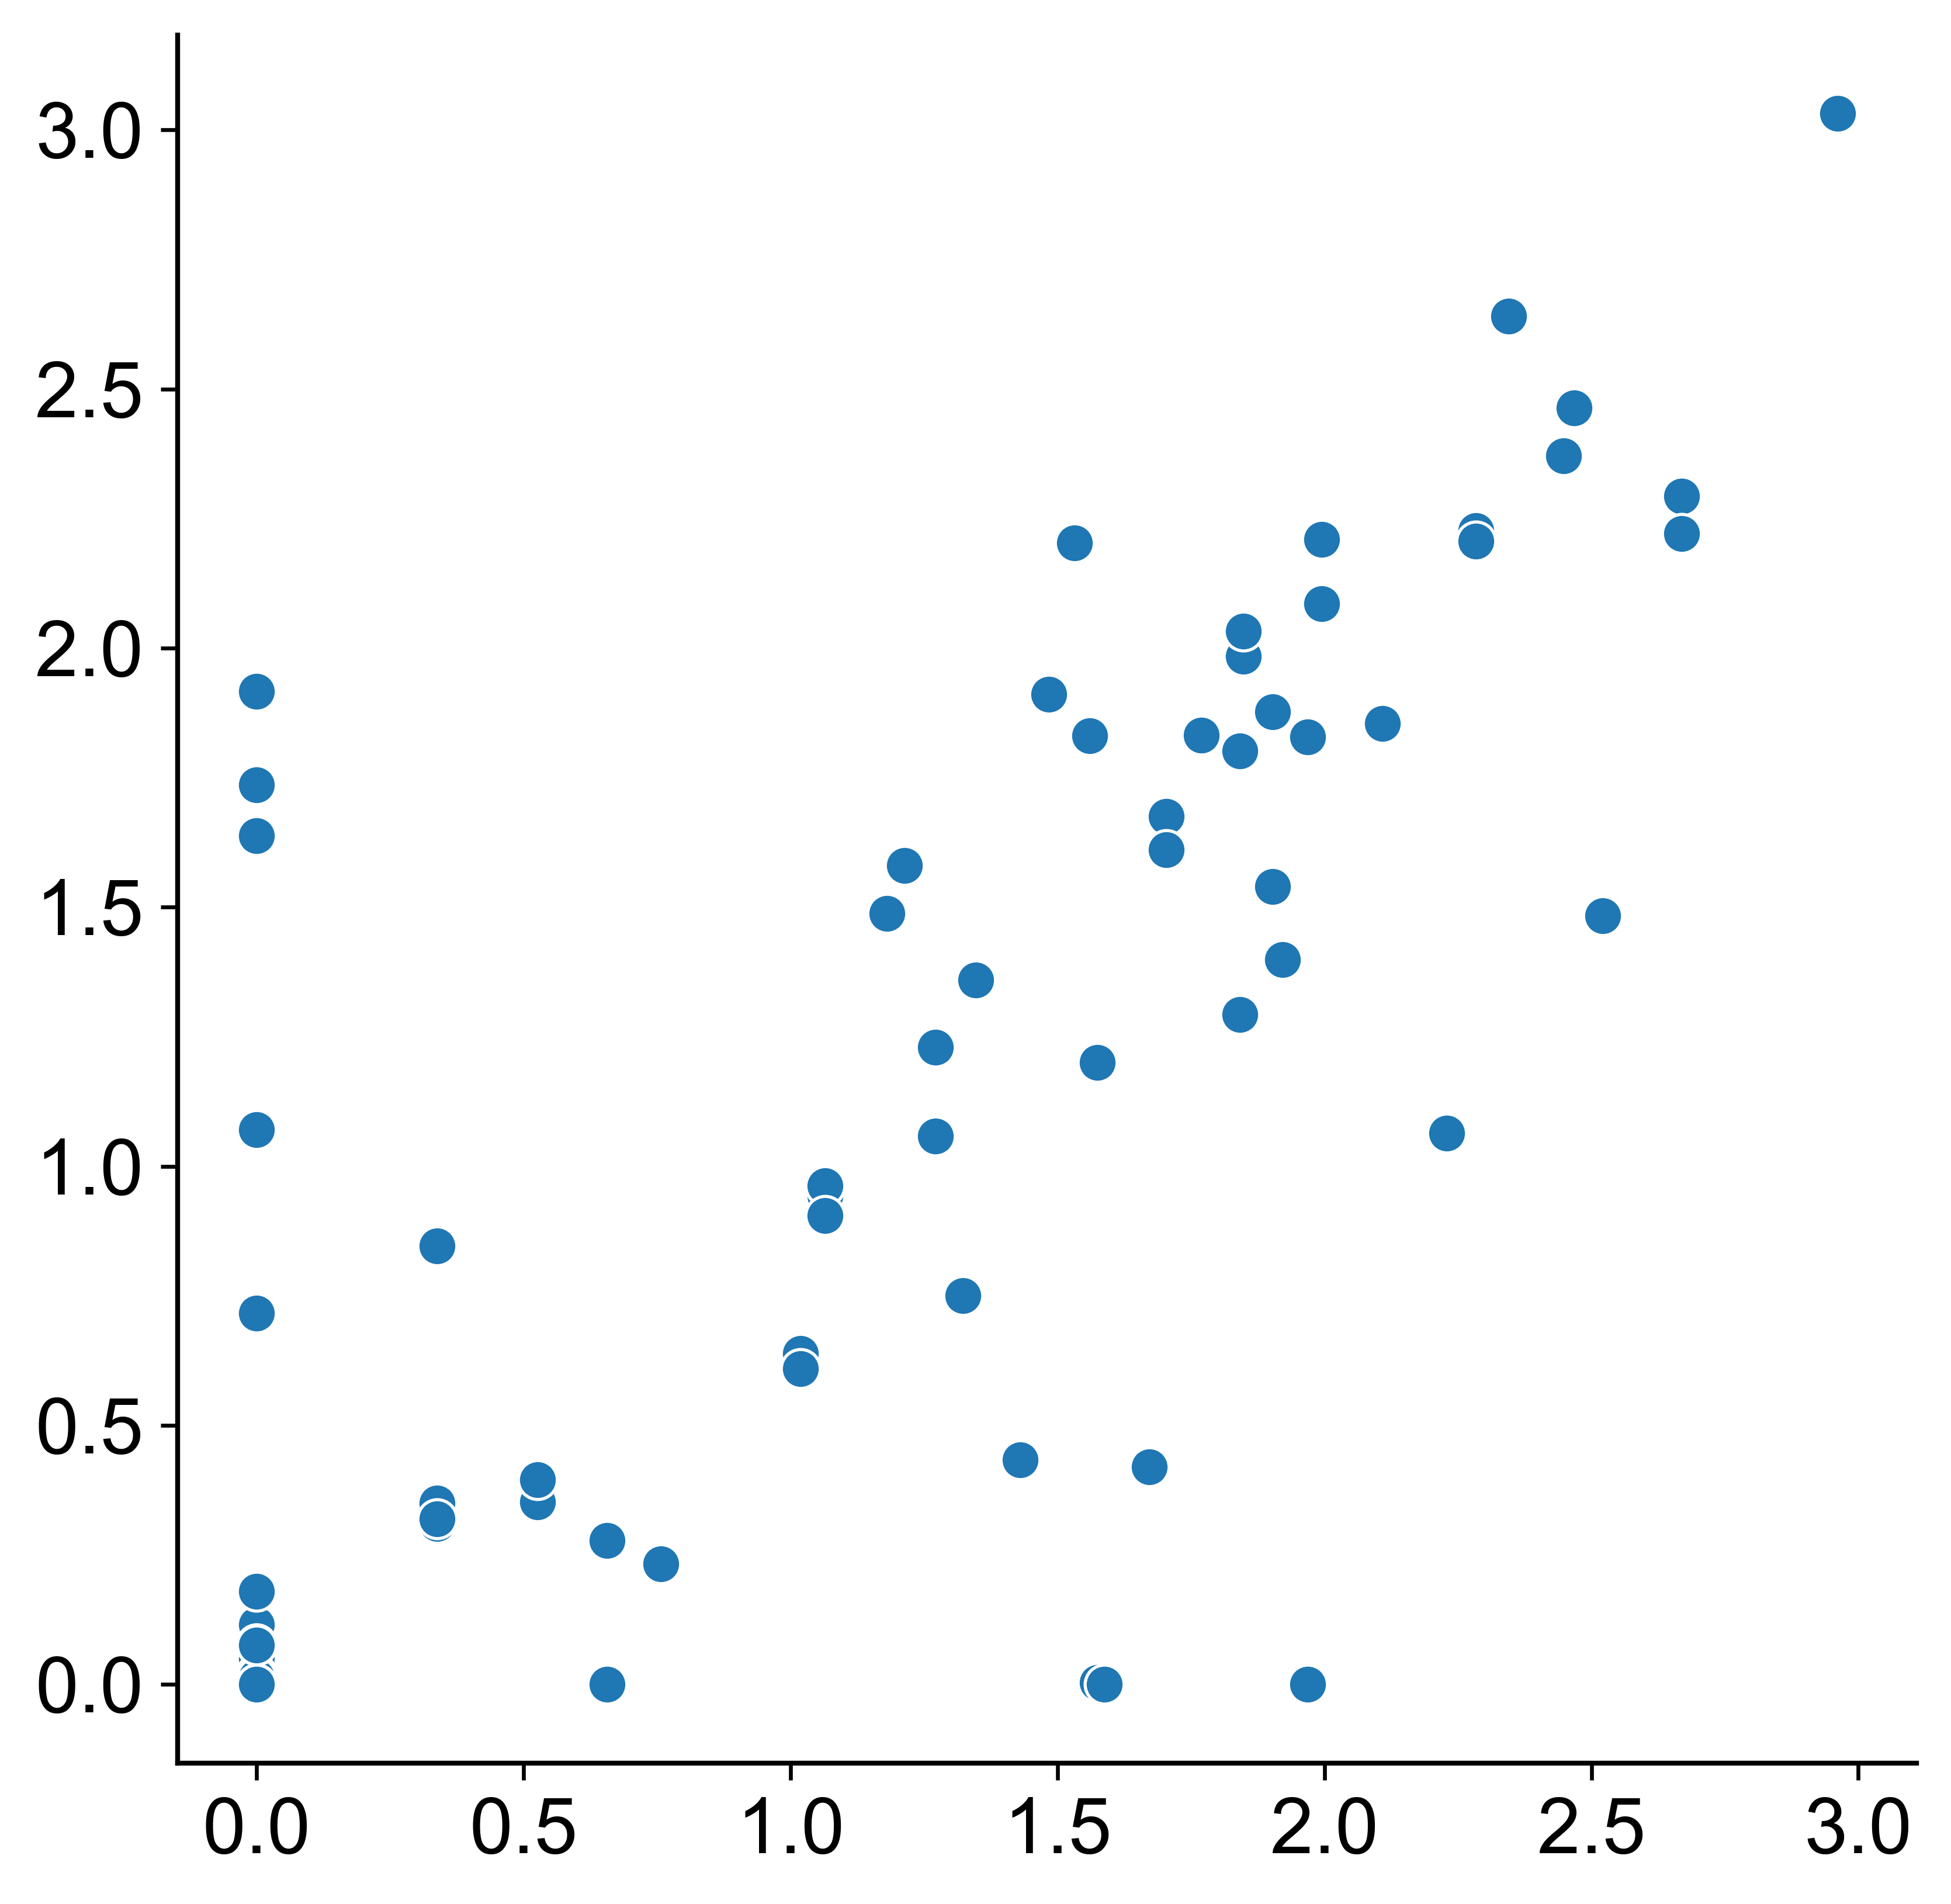

In [4]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)

It's almost converged so I stopped it.

# Interpretation

After finetuning, we can use the checkpoint to predict expression of all accessible genes and generate jacobian matrix of (peak x motif) for every predicted genes. 
To start, we need to collect the checkpoint we produced and switch to `predict` stage. Here, let's focus on CD4 Naive cell and we need to set `cfg.leave_out_celltypes` to `cd4_naive` for the model to predict gene expression in this cell type.

In [6]:
use_checkpoint = '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints/best.ckpt'
cfg.stage = 'predict'
cfg.finetune.resume_ckpt = use_checkpoint
# in predict stage, leave out the celltype you want to interpret
cfg.run.use_wandb=False # disable wandb logging when predicting
cfg.task.layer_names = [] # set to empty list to disable intermediate layer interpretation
cfg.task.gene_list = None # set to None to predict all genes; otherwise you can specify a list of genes as 'MYC,SOX10,SOX2,RET', only genes with promoter open will be used
# loop through all celltypes and run the predict stage
cfg.run.run_name='interpret_training_from_finetune_lora_chr10_chr11_split_QATAC'

for celltype in celltype_for_modeling:
    cfg.dataset.leave_out_celltypes = celltype 
    trainer = run(cfg)

# Pearson 0.896
# R^2 0.793
# Spearman 0.803



Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/memory_b.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/memory_b.zarr


epoch,▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
exp_pearson,▁▃▅▆▇▇▇▇▇█▇██▇███████████████████▇██████
exp_r2,▁▃▄▆▆▇▇▇▇▇▇▇█▇▇▇▇████████████▇██████████
exp_spearman,▁▄▆▇▇▇█▇█▇█▇█▇▇██████████████▇██████████
train_exp_loss,▇█▅▂▂▂▃▂▂▃▂▂▃▁▃▄▃▂▂▁▁▁▁▅▅▂▃▂▂▄▂▂▂▂▂▃▃▄▁▄
train_loss,▆▄▅▄▅▃▄▃▅▄▆▂▄▄▃▃█▂▃▄▁▁▃▂▃▃▃▁▄▄▃▂▂▃▄▅▄▃▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
val_exp_loss,█▃▃▂▂▂▂▂▁▂▁▂▂▂▂▂▁▁▂▂▄▄▃▂▃▂▂▂▂▂▂▂▃▃▂▃▃▃▃▃
val_loss,█▆▄▂▂▃▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂
epoch,36
exp_pearson,0.8963


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:05<00:00,  5.77s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd14_mono.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd14_mono.zarr
Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd14_mono.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/gdt.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/gdt.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:04<00:00,  4.46s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd8_tem_1.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd8_tem_1.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/naive_b.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/naive_b.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/mait.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/mait.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:04<00:00,  4.82s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/intermediate_b.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/intermediate_b.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd4_naive.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd4_naive.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd8_tem_2.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd8_tem_2.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']


100%|██████████| 1/1 [00:05<00:00,  5.27s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd8_naive.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_chr10_chr11_split_QATAC/cd8_naive.zarr


OSError: [Errno 28] No space left on device

As you can see, the results is now saved to `finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split/cd4_naive.zarr`. Now we can use the `GETHydraCellType` class from `gcell` to load it.

## Load interpretation result as `GETHydraCellType`

In [73]:
# get the celltype object based on the configuration
celltype = 'cd4_naive'
cfg = load_config('finetune_tutorial_pbmc')
cfg.run.run_name='interpret_training_from_finetune_lora_chr10_chr11_split_QATAC'
cfg.dataset.leave_out_celltypes = celltype
gene_annot_dict = {}
# cd14_mono.zarr  cd4_naive.zarr  cd8_naive.zarr  cd8_tem_1.zarr  cd8_tem_2.zarr  csv_logs  gdt.zarr  intermediate_b.zarr  mait.zarr  memory_b.zarr  naive_b.zarr
for celltype in ['cd14_mono',  'cd8_tem_1', 'cd8_tem_2', 'gdt', 'intermediate_b', 'mait', 'memory_b', 'naive_b']:
    try:
        cfg.dataset.leave_out_celltypes = celltype
        hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
        gene_annot_dict[celltype] = hydra_celltype.gene_annot
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue


In [74]:
# for each gene, collect the predicted and observed expression from all celltypes
# get a common intersected gene list first
import numpy as np
import pandas as pd

common_gene_list = set(gene_annot_dict[celltype_for_modeling[3]].index)
for celltype in celltype_for_modeling:
    try:
        common_gene_list = common_gene_list.intersection(set(gene_annot_dict[celltype].index))
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# then collect the expression
for celltype in celltype_for_modeling:
    try:
        gene_annot_dict[celltype] = gene_annot_dict[celltype].loc[np.array(common_gene_list)]
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# make a dataframe with the expression in each celltype for all genes
gene_annot_dict


Error loading cd4_naive: 'cd4_naive'
Error loading cd8_naive: 'cd8_naive'
Error loading cd4_tem: 'cd4_tem'
Error loading cd4_tcm: 'cd4_tcm'
Error loading cd16_mono: 'cd16_mono'
Error loading nk: 'nk'
Error loading cdc: 'cdc'
Error loading treg: 'treg'
Error loading cd4_naive: 'cd4_naive'
Error loading cd8_naive: 'cd8_naive'
Error loading cd4_tem: 'cd4_tem'
Error loading cd4_tcm: 'cd4_tcm'
Error loading cd16_mono: 'cd16_mono'
Error loading nk: 'nk'
Error loading cdc: 'cdc'
Error loading treg: 'treg'


{'cd14_mono':      gene_name Chromosome      Start        End  Strand          pred  \
 0     A1BG-AS1      chr19   58347204   58348072       0  1.289727e-06   
 1          A2M      chr12    9115994    9116846       1  1.074687e-06   
 2       A4GALT      chr22   42720120   42721040       1  3.970009e-02   
 3         AAAS      chr12   53321020   53321944       1  9.139374e-01   
 4         AAAS      chr12   53324452   53325224       1  3.324911e-01   
 ...        ...        ...        ...        ...     ...           ...   
 9697     NOP58       chr2  202265248  202266160       0  2.303769e+00   
 9698     NORAD      chr20   36050488   36051332       1  2.406486e-06   
 9699    NOS1AP       chr1  162069280  162070160       0  7.565422e-07   
 9700      NOS2      chr17   27793288   27794152       1  4.932655e-02   
 9701     NOSIP      chr19   49580160   49581060       1  2.048197e+00   
 
            obs  accessibility  
 0     0.000000       0.040344  
 1     0.000000       0.011276 

In [76]:
gene_annot_dict['cd14_mono']


,gene_name,Chromosome,Start,End,Strand,pred,obs,accessibility
0,A1BG-AS1,chr19,58347204,58348072,0,1.289727e-06,0.000000,0.040344
1,A2M,chr12,9115994,9116846,1,1.074687e-06,0.000000,0.011276
2,A4GALT,chr22,42720120,42721040,1,3.970009e-02,0.033342,0.201904
3,AAAS,chr12,53321020,53321944,1,9.139374e-01,0.941528,0.157104
4,AAAS,chr12,53324452,53325224,1,3.324911e-01,0.000000,0.061981
...,...,...,...,...,...,...,...,...
9697,NOP58,chr2,202265248,202266160,0,2.303769e+00,1.883141,0.684570
9698,NORAD,chr20,36050488,36051332,1,2.406486e-06,0.000000,0.041138
9699,NOS1AP,chr1,162069280,162070160,0,7.565422e-07,0.000000,0.021896
9700,NOS2,chr17,27793288,27794152,1,4.932655e-02,0.000000,0.386230


In [79]:
dfs = []
for celltype in gene_annot_dict.keys():
    df = gene_annot_dict[celltype].query('Chromosome == "chr10" | Chromosome == "chr11"')\
        .reset_index()[['obs', 'pred', 'gene_name']] \
        .groupby('gene_name').mean().reset_index()
    df['celltype'] = celltype
    dfs.append(df)
df = pd.concat(dfs)
df_pred = df.pivot(index='gene_name', columns='celltype', values='pred').dropna()
df_obs = df.pivot(index='gene_name', columns='celltype', values='obs').dropna()

# for each gene calculate the correlation between predicted and observed expression
corrs = []
for gene in df_pred.index:
    try:
        corr = df_pred.loc[gene].corr(df_obs.loc[gene])
        corrs.append((corr, df_pred.loc[gene].mean(), df_obs.loc[gene].mean(), gene))
    except Exception as e:
        print(f"Error calculating correlation for {gene}: {e}")
        continue
df_corr = pd.DataFrame(corrs, columns=['corr', 'pred', 'obs', 'gene_name'])



invalid value encountered in divide
invalid value encountered in divide




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



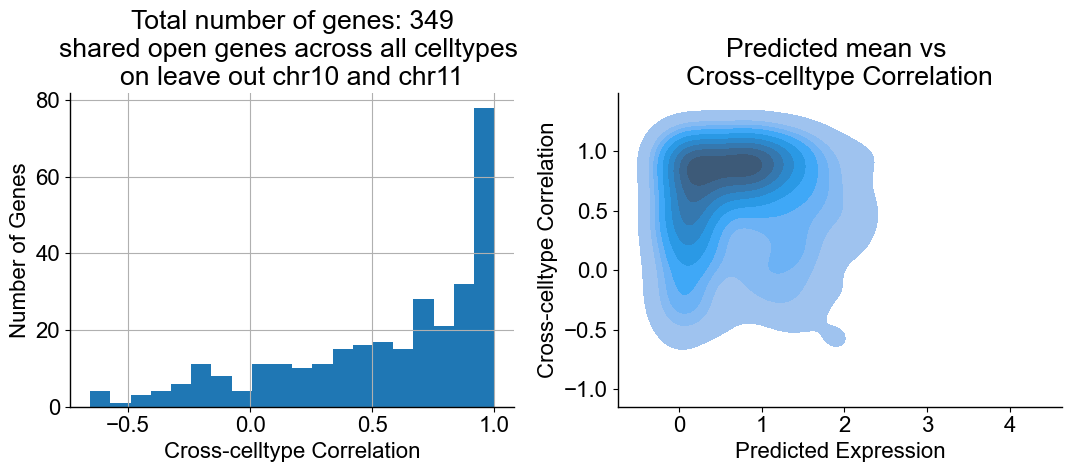

In [87]:
# plot example genes
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
df_corr['corr'].hist(bins=20, ax=ax[0])
# add total number of genes as title
ax[0].set_title(f'Total number of genes: {len(df_corr)}\nshared open genes across all celltypes \non leave out chr10 and chr11')
ax[0].set_xlabel('Cross-celltype Correlation')
ax[0].set_ylabel('Number of Genes')

sns.kdeplot(data=df_corr, x='pred', y='corr', ax=ax[1], shade=True)
ax[1].set_title('Predicted mean vs \nCross-celltype Correlation')
ax[1].set_xlabel('Predicted Expression')
ax[1].set_ylabel('Cross-celltype Correlation')
fig.tight_layout()


We can plot the predicted and observed expression to see whether there is any issue.

In [57]:
df_pred

celltype,cd14_mono,cd4_naive,cd8_naive,cd8_tem_1,cd8_tem_2,gdt,intermediate_b,mait,memory_b,naive_b
gene_name,,,,,,,,,,
ABCG4,0.059699,0.000494,0.001192,0.000804,0.004144,0.001518,0.000612,0.005958,0.000616,0.001400
ABLIM1,0.914590,1.157158,1.101222,0.000004,0.917882,0.000003,0.645226,0.755538,0.378033,0.624651
ABTB2,0.000002,0.357003,0.366728,0.414682,0.386676,0.345993,0.385420,0.329610,0.241438,0.000106
ACBD5,0.647366,0.000002,0.000002,0.000002,0.000002,0.000003,1.048037,0.000002,0.538649,0.813668
ACCS,0.001471,0.001832,0.002271,0.001930,0.031373,0.017007,0.005571,0.105759,0.000677,0.001632
...,...,...,...,...,...,...,...,...,...,...
LINC02725,0.700050,0.839723,0.034813,1.026281,1.070134,1.109070,0.824901,1.207952,0.630197,0.206810
LINC02731,0.000021,0.000011,0.000014,0.000036,0.000059,0.000114,0.000040,0.000018,0.000107,0.000100
LINC02745,0.000002,0.000027,0.000014,0.000015,0.000086,0.000106,0.000006,0.000053,0.000009,0.000029
